In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 53.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=076366ae283c9cae7a4852126ef5c959946fce137226e3b650e4fd52c118426d
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DateType, DoubleType
from pyspark.sql.functions import col,lit
from pyspark.storagelevel import StorageLevel

# Usual Suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
import seaborn as sns
# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# SM stuff
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pyspark


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Mount/Unmount drive in colab:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()


Mounted at /content/drive


In [ ]:

from pyspark.sql import SparkSession

spark = (SparkSession
         .builder
         .appName("pollutionStreamer")
         .getOrCreate()
        )

lines = (
    spark.read.format("csv")
                .options(header='True')
                .options(inferSchema='True')
                .load("/content/drive/MyDrive/Tutorials/3rd Sem/DATA 603 Big Data/Final_Project/pollution_us_2000_2016.csv")
)

lines.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- State Code: integer (nullable = true)
 |-- County Code: integer (nullable = true)
 |-- Site Num: integer (nullable = true)
 |-- Address: string (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Date Local: string (nullable = true)
 |-- NO2 Units: string (nullable = true)
 |-- NO2 Mean: double (nullable = true)
 |-- NO2 1st Max Value: double (nullable = true)
 |-- NO2 1st Max Hour: integer (nullable = true)
 |-- NO2 AQI: integer (nullable = true)
 |-- O3 Units: string (nullable = true)
 |-- O3 Mean: double (nullable = true)
 |-- O3 1st Max Value: double (nullable = true)
 |-- O3 1st Max Hour: integer (nullable = true)
 |-- O3 AQI: integer (nullable = true)
 |-- SO2 Units: string (nullable = true)
 |-- SO2 Mean: double (nullable = true)
 |-- SO2 1st Max Value: double (nullable = true)
 |-- SO2 1st Max Hour: integer (nullable = true)
 |-- SO2 AQI: double (nulla

In [ ]:
lines.show(5)

+---+----------+-----------+--------+--------------------+-------+--------+-------+----------+-----------------+---------+-----------------+----------------+-------+-----------------+--------+----------------+---------------+------+-----------------+--------+-----------------+----------------+-------+-----------------+--------+----------------+---------------+------+
|_c0|State Code|County Code|Site Num|             Address|  State|  County|   City|Date Local|        NO2 Units| NO2 Mean|NO2 1st Max Value|NO2 1st Max Hour|NO2 AQI|         O3 Units| O3 Mean|O3 1st Max Value|O3 1st Max Hour|O3 AQI|        SO2 Units|SO2 Mean|SO2 1st Max Value|SO2 1st Max Hour|SO2 AQI|         CO Units| CO Mean|CO 1st Max Value|CO 1st Max Hour|CO AQI|
+---+----------+-----------+--------+--------------------+-------+--------+-------+----------+-----------------+---------+-----------------+----------------+-------+-----------------+--------+----------------+---------------+------+-----------------+--------+-

In [ ]:
lines.cache()
lines.count()

1746661

In [ ]:
#lines.count()
lines.select("Date Local").distinct().show()

+----------+
|Date Local|
+----------+
|2000-11-13|
|2000-09-23|
|2001-04-22|
|2001-11-16|
|2002-05-13|
|2002-06-21|
|2003-02-22|
|2003-05-29|
|2003-11-06|
|2006-09-24|
|2006-11-04|
|2000-07-11|
|2000-10-25|
|2001-01-23|
|2002-04-15|
|2002-08-25|
|2004-03-10|
|2004-06-27|
|2004-12-03|
|2005-02-01|
+----------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import countDistinct, avg
from pyspark.sql.functions import desc
dfGroupBy = lines.groupBy("State").agg(avg("NO2 AQI").alias("NO2 AQI"), \
                                       avg("O3 AQI").alias("O3 AQI"), \
                                       avg("SO2 AQI").alias("SO2 AQI"), \
                                       avg("CO AQI").alias("CO AQI")) \
.sort("State") \
.show(5)

+----------+------------------+------------------+------------------+------------------+
|     State|           NO2 AQI|            O3 AQI|           SO2 AQI|            CO AQI|
+----------+------------------+------------------+------------------+------------------+
|   Alabama|21.232245681381958|36.845169545745364| 7.005115089514066|3.8502879078694816|
|    Alaska|  19.5531914893617|17.725430597771023|14.487335359675786|  6.52834008097166|
|   Arizona| 36.10698739977091|  39.0040950744559|4.2134860415175375| 9.191022815103198|
|  Arkansas|21.486471187591984| 35.03566172308389|2.9757726706668177| 5.929913949275362|
|California| 24.11023844816035|35.722672535590185|3.5982784701212913| 7.405668957856002|
+----------+------------------+------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import countDistinct, avg, col
from pyspark.sql.functions import desc
dfGroupBy = lines.withColumn("Month", col("Date Local").substr(6, 2)) \
.groupBy("State", "Month").agg(avg("NO2 AQI").alias("NO2 AQI"), \
                                       avg("O3 AQI").alias("O3 AQI"), \
                                       avg("SO2 AQI").alias("SO2 AQI"), \
                                       avg("CO AQI").alias("CO AQI")) \
.sort("State", "Month") \
.show(5)

+-------+-----+------------------+------------------+-----------------+------------------+
|  State|Month|           NO2 AQI|            O3 AQI|          SO2 AQI|            CO AQI|
+-------+-----+------------------+------------------+-----------------+------------------+
|Alabama|   01|23.289473684210527|27.236842105263158|4.947368421052632| 4.815789473684211|
|Alabama|   02|            22.075|             32.75|             4.85|              4.15|
|Alabama|   03|21.595238095238095| 34.07142857142857|6.976190476190476|3.6785714285714284|
|Alabama|   04|22.177777777777777|39.233333333333334|4.877777777777778|3.2777777777777777|
|Alabama|   05|23.055555555555557|              50.7|8.577777777777778|3.6666666666666665|
+-------+-----+------------------+------------------+-----------------+------------------+
only showing top 5 rows



In [ ]:
# Determining AQI datewise and colour grading as per quality

from pyspark.sql.functions import *

#dfCoalesce = lines.withColumn("AQI", (coalesce(col("NO2 AQI"), lit(0)) + coalesce(col("O3 AQI"), lit(0)) + coalesce(col("SO2 AQI"), lit(0)) + coalesce(col("CO AQI"), lit(0)))/4) \
dfCoalesce = lines.withColumn("AQI", greatest(coalesce(col("NO2 AQI"), lit(0)), coalesce(col("O3 AQI"), lit(0)), coalesce(col("SO2 AQI"), lit(0)), coalesce(col("CO AQI"), lit(0)))) \
.withColumn("AQI Color", when((col("AQI") >= 0) & (col("AQI") <= 50), "GREEN")
            .when((col("AQI") >= 51) & (col("AQI") <= 100), "YELLOW")
            .when((col("AQI") >= 101) & (col("AQI") <= 150), "ORANGE")
            .when((col("AQI") >= 151) & (col("AQI") <= 200), "RED")
            .when((col("AQI") >= 201) & (col("AQI") <= 300), "PURPLE")
            .otherwise(lit("MAROON")))\
.select("State", "Date Local", col("NO2 AQI"), col("O3 AQI"), col("SO2 AQI"),  col("CO AQI"), "AQI", "AQI Color")\
.where(col("State") == "Arizona") \
.show(50)

+-------+----------+-------+------+-------+------+-----+---------+
|  State|Date Local|NO2 AQI|O3 AQI|SO2 AQI|CO AQI|  AQI|AQI Color|
+-------+----------+-------+------+-------+------+-----+---------+
|Arizona|2000-01-01|     46|    34|   13.0|  null| 46.0|    GREEN|
|Arizona|2000-01-01|     46|    34|   13.0|  25.0| 46.0|    GREEN|
|Arizona|2000-01-01|     46|    34|   null|  null| 46.0|    GREEN|
|Arizona|2000-01-01|     46|    34|   null|  25.0| 46.0|    GREEN|
|Arizona|2000-01-02|     34|    27|    4.0|  null| 34.0|    GREEN|
|Arizona|2000-01-02|     34|    27|    4.0|  26.0| 34.0|    GREEN|
|Arizona|2000-01-02|     34|    27|   null|  null| 34.0|    GREEN|
|Arizona|2000-01-02|     34|    27|   null|  26.0| 34.0|    GREEN|
|Arizona|2000-01-03|     48|    14|   16.0|  null| 48.0|    GREEN|
|Arizona|2000-01-03|     48|    14|   16.0|  28.0| 48.0|    GREEN|
|Arizona|2000-01-03|     48|    14|   null|  null| 48.0|    GREEN|
|Arizona|2000-01-03|     48|    14|   null|  28.0| 48.0|    GR

In [ ]:
## 10 laks rows were taken 

new_df= lines.limit(1000000)
#new_df.show(50)

## Converting to Pandas dataframe
pandasDF=new_df.toPandas()
#pandasDF.info()
pandasDF.head(2)

,_c0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0


In [ ]:
## Getting required columns from the state of Arizona for plotting 
df_Arizona = pandasDF[pandasDF['State Code'] == 4]
df1_Arizona= df_Arizona[['NO2 AQI', 'O3 AQI','SO2 AQI','CO AQI','Date Local']]

# Dataframe for model fitting
pandasDF['AQI'] = pandasDF[['NO2 AQI','O3 AQI','SO2 AQI','CO AQI']].max(axis=1)
pandasDF['month'] = pd.DatetimeIndex(pandasDF['Date Local']).month
pandasDF.head(2)

,_c0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,AQI,month
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN,46.0,1
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0,46.0,1


In [ ]:
## Making month column from Arizona date local
df1_Arizona['month'] = pd.DatetimeIndex(df1_Arizona['Date Local']).month

## Inserting month column in Data frame for curve fitting
df_New['month'] = pd.DatetimeIndex(df_New['Date Local']).month
df_New

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,Date Local,month
0,46,34,13.0,NaN,2000-01-01,1
1,46,34,13.0,25.0,2000-01-01,1
2,46,34,NaN,NaN,2000-01-01,1
3,46,34,NaN,25.0,2000-01-01,1
4,34,27,4.0,NaN,2000-01-02,1
...,...,...,...,...,...,...
999995,9,36,0.0,NaN,2010-03-31,3
999996,9,36,0.0,2.0,2010-03-31,3
999997,9,36,NaN,NaN,2010-03-31,3
999998,9,36,NaN,2.0,2010-03-31,3


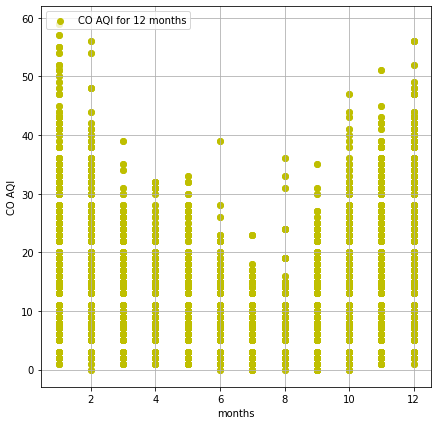

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7] # for square canvas

x_month=df1_Arizona['month'].to_list()
y_co=df1_Arizona['CO AQI'].to_list()

plt.scatter(x_month,y_co, color='y',label='CO AQI for 12 months')
plt.legend(loc=2)
plt.xlabel("months")
plt.ylabel("CO AQI")
plt.grid()

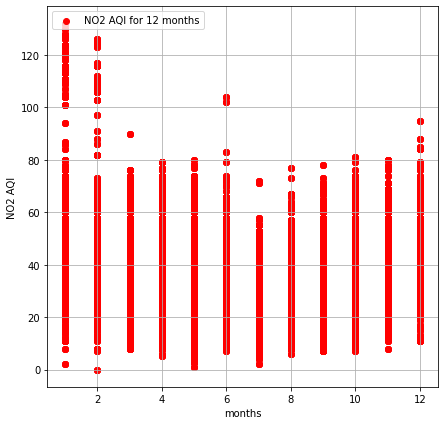

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7] # for square canvas

x_month=df1_Arizona['month'].to_list()
y_NO2=df1_Arizona['NO2 AQI'].to_list()

plt.scatter(x_month,y_NO2, color='r',label='NO2 AQI for 12 months')
plt.legend(loc=2)
plt.xlabel("months")
plt.ylabel("NO2 AQI")
plt.grid()


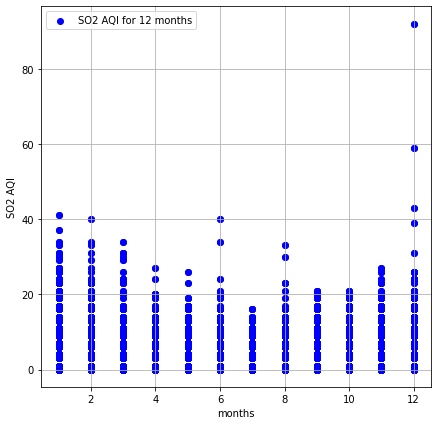

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7] # for square canvas

x_month=df1_Arizona['month'].to_list()
y_SO2=df1_Arizona['SO2 AQI'].to_list()

plt.scatter(x_month,y_SO2, color='b',label='SO2 AQI for 12 months')
plt.legend(loc=2)
plt.xlabel("months")
plt.ylabel("SO2 AQI")
plt.grid()

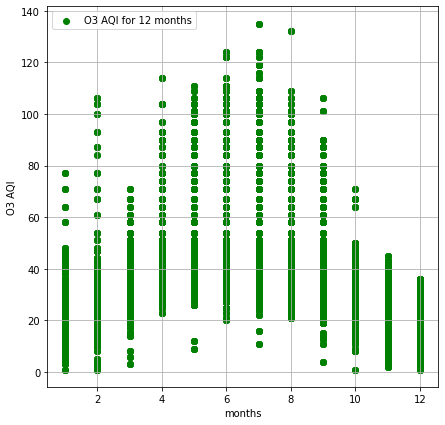

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7] # for square canvas

x_month=df1_Arizona['month'].to_list()
y_o3=df1_Arizona['O3 AQI'].to_list()

plt.scatter(x_month,y_o3, color='g',label='O3 AQI for 12 months')
plt.legend(loc=2)
plt.xlabel("months")
plt.ylabel("O3 AQI")
plt.grid()

In [ ]:
## Using correlation matrix to find best featured columns

pandasDF.corr()

,_c0,State Code,County Code,Site Num,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,AQI,month
_c0,1.000000,0.926546,0.330962,-0.251911,-0.161079,-0.132793,-0.011549,-0.133296,0.058559,0.048284,-0.001366,0.052200,0.219877,0.220339,0.075494,0.235463,-0.252804,-0.227339,-0.028846,-0.240189,-0.001509,0.032687
State Code,0.926546,1.000000,0.247638,-0.238344,-0.087068,-0.055555,0.019856,-0.056335,0.039251,0.064000,-0.002272,0.070081,0.256048,0.243854,0.099593,0.259071,-0.211412,-0.168347,-0.010046,-0.183183,0.038344,0.019295
County Code,0.330962,0.247638,1.000000,-0.156223,-0.089506,-0.062899,-0.010441,-0.062956,0.069375,0.056918,-0.007492,0.052128,0.014538,0.057210,-0.002856,0.068315,-0.101142,-0.088454,-0.003965,-0.092761,0.009625,0.016253
Site Num,-0.251911,-0.238344,-0.156223,1.000000,0.041105,0.048276,-0.011008,0.048481,0.032999,0.055627,0.001615,0.042449,-0.115165,-0.104625,-0.046053,-0.109586,0.031307,0.040826,-0.017890,0.038539,0.058097,-0.001243
NO2 Mean,-0.161079,-0.087068,-0.089506,0.041105,1.000000,0.899582,0.107943,0.900993,-0.430739,-0.168912,0.019510,-0.084634,0.320540,0.247600,0.122713,0.259691,0.651344,0.633111,0.185941,0.657234,0.340171,0.010719
NO2 1st Max Value,-0.132793,-0.055555,-0.062899,0.048276,0.899582,1.000000,0.148574,0.996972,-0.278815,0.003704,0.017309,0.055087,0.268603,0.227061,0.134041,0.242368,0.573294,0.603972,0.230984,0.609861,0.432592,-0.017099
NO2 1st Max Hour,-0.011549,0.019856,-0.010441,-0.011008,0.107943,0.148574,1.000000,0.148170,-0.203213,-0.084679,-0.125569,-0.081482,0.024734,0.018280,0.167460,0.017602,0.056474,0.075722,0.382484,0.052773,-0.034755,0.036582
NO2 AQI,-0.133296,-0.056335,-0.062956,0.048481,0.900993,0.996972,0.148170,1.000000,-0.279364,0.003980,0.017257,0.055863,0.270307,0.228551,0.134027,0.243995,0.576136,0.606834,0.231022,0.612729,0.434665,-0.016366
O3 Mean,0.058559,0.039251,0.069375,0.032999,-0.430739,-0.278815,-0.203213,-0.279364,1.000000,0.867330,0.061935,0.775246,-0.101910,-0.060517,-0.080623,-0.058551,-0.346504,-0.349155,-0.210101,-0.360095,0.490682,-0.142628
O3 1st Max Value,0.048284,0.064000,0.056918,0.055627,-0.168912,0.003704,-0.084679,0.003980,0.867330,1.000000,0.065306,0.933290,-0.015220,0.032300,-0.010689,0.042399,-0.203335,-0.186123,-0.108417,-0.202037,0.702964,-0.078303


####  O3 AQI ,O3 1st Max Value seem to be the best featured column from the correlation matrix

In [ ]:
from sklearn.linear_model import LinearRegression


dfP = pandasDF
# Preparing the data for training the model after selecting feature columns from the correlation matrix

X = pd.DataFrame(np.c_[dfP['O3 1st Max Value'],dfP['O3 AQI']], columns = ['O3 1st Max Value','O3 AQI'])
Y = dfP['AQI']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800000, 2)
(200000, 2)
(800000,)
(200000,)


In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [ ]:
# Model evaluation
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
max_relative_error = 100*np.amax(np.absolute((Y_train-y_train_predict)/Y_train))
r2 = r2_score(Y_train, y_train_predict)


# Model evaluation
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
max_relative_error = 100*np.amax(np.absolute((Y_train-y_train_predict)/Y_train))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('max_relative_error is {}'.format(max_relative_error))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
max_relative_error = 100*np.amax(np.absolute((Y_train-y_train_predict)/Y_train))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('max_relative_error is {}'.format(max_relative_error))
print('R2 score is {}'.format(r2))


The model performance for training set
--------------------------------------
max_relative_error is 1102.8025929045662
R2 score is 0.7354886276767999


The model performance for testing set
--------------------------------------
max_relative_error is 1102.8025929045662
R2 score is 0.7331229461530755
